In [1]:
import mediapipe as mp
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import threading


In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
mp_pose = mp.solutions.pose

In [3]:
useful_pose_landmarks_index = [0, 7, 8, 9, 10, 11, 12, 13, 14]

_hand_connections_1 = [pair for pair in mp_hands.HAND_CONNECTIONS]
_hand_connections_2 = [(pair[0] + 21, pair[1] + 21) for pair in mp_hands.HAND_CONNECTIONS]
_pose_connections_nohands = [(0, 1), (0, 2), (1, 2),
                             (0, 3), (0, 4), (3, 4),
                             (5, 6), (5, 7), (6, 8),
                             (1, 3), (2, 4)]
_pose_connections_1hand = [(pair[0] + 21, pair[1] + 21) for pair in _pose_connections_nohands]
_pose_connections_2hands = [(pair[0] + 42, pair[1] + 42) for pair in _pose_connections_nohands]

In [4]:
def connections(num_hands: int = 0, classification: list = [], pose: bool = False):
    global _hand_connections_1, _hand_connections_2, _pose_connections_nohands, _pose_connections_1hand, _pose_connections_2hands
    
    if num_hands == 0 and pose:
        out = _pose_connections_nohands
    elif num_hands == 1:
        out = _hand_connections_1 + _pose_connections_1hand if pose else _hand_connections_1
    elif num_hands == 2:
        out = _hand_connections_1 + _hand_connections_2 + _pose_connections_2hands if pose else _hand_connections_1 + _hand_connections_2
    else:
        out = []

    if num_hands != 0 and pose and classification:
        if num_hands == 1:
            out += [(0, 29)] if classification[0] == 'left' else [(0, 28)]
        elif num_hands == 2:
            out += [(0, 50), (21, 49)] # if classification[0] == 'left' else [(0, 49), (21, 50)]
        else:
            pass

    return out

In [5]:
from mediapipe.framework.formats import landmark_pb2

NormLandmark = mp.tasks.components.containers.NormalizedLandmark
NormLandmarkList = landmark_pb2.NormalizedLandmarkList

def detect_upperbody(frame, hands, pose, only_52: bool = False, centered: bool = False):

    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image = cv2.flip(image, 1)
    image.flags.writeable = False
    hands_results = hands.process(image)
    pose_results = pose.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    container = []

    num_hands_detected = 0 if bool(hands_results.multi_hand_landmarks) == False else len(hands_results.multi_hand_landmarks)
    hand_classifications = [side.classification[0].label.lower() for side in hands_results.multi_handedness] if bool(hands_results.multi_handedness) else []
    pose_detected = bool(pose_results.pose_landmarks)

    if hands_results.multi_hand_landmarks:
        if hand_classifications[0] == 'left':
            for i, landmarks in enumerate(hands_results.multi_hand_landmarks):
                container = container + list(landmarks.landmark)
        else:
            for i, landmarks in enumerate(hands_results.multi_hand_landmarks):
                container = list(landmarks.landmark) + container
    
    if pose_results.pose_landmarks:
        for index in useful_pose_landmarks_index:
            container.append(pose_results.pose_landmarks.landmark[index])

        #### center landmark coords
        # this will be a reference point when processing the data for model training and visualization

        x = (pose_results.pose_landmarks.landmark[11].x + pose_results.pose_landmarks.landmark[12].x)/2
        y = (pose_results.pose_landmarks.landmark[11].y + pose_results.pose_landmarks.landmark[12].y)/2
        z = (pose_results.pose_landmarks.landmark[11].z + pose_results.pose_landmarks.landmark[12].z)/2
        visibility = (pose_results.pose_landmarks.landmark[11].visibility + pose_results.pose_landmarks.landmark[12].visibility)/2

        # center_landmark = NormLandmark(x = x, y = y, z = z)
        # container.append(center_landmark)

        # when creating an instance of a NormalizedLandmarkList with center_landmark appended to the iterable, it gives the error below:
        # TypeError: Parameter to MergeFrom() must be instance of same class: expected mediapipe.NormalizedLandmark got NormalizedLandmark.

        center_landmark = pose_results.pose_landmarks.landmark[15]
        center_landmark.x = x
        center_landmark.y = y
        center_landmark.z = z
        center_landmark.visibility = visibility

        container.append(center_landmark)

        # this will be a workaround for now because of the error that i do not know how to fix,.
    if centered :
        if not pose_results.pose_landmarks:
            raise ValueError('Since there are no pose landmarks, there is no center point you fuckwit')
        for landmark in container:
            landmark.x -= container[-1].x
            landmark.y -= container[-1].y
            landmark.z -= container[-1].z

    if only_52 and container:
        useful_landmarks = NormLandmarkList(landmark = container) if len(container) == 52 else NormLandmarkList()
    else:
        useful_landmarks = NormLandmarkList(landmark = container) if container else NormLandmarkList()

    connection_data = connections(num_hands = num_hands_detected, classification = hand_classifications, pose = pose_detected) if useful_landmarks.landmark else []

    return image, useful_landmarks, connection_data

In [6]:
def center_xyzcoord(coordinates: list = []):
    if coordinates:
        for i, coord in enumerate(coordinates):
            coord[0] -= coordinates[-1][0]
            coord[1] -= coordinates[-1][1]
            coord[2] -= coordinates[-1][2]
    return coordinates

def landmarklist_to_xyzcoord(landmark_list, all_52 : bool = True, centered: bool = False):
    # landmark_list must be a NormalizedLandmarkList Object
    if landmark_list.landmark:
        if all_52:
            landmark_coordiantes = [[landmark.x, landmark.y, landmark.z] for landmark in landmark_list.landmark] if len(landmark_list.landmark) == 52 else []
        else:
            landmark_coordiantes = [[landmark.x, landmark.y, landmark.z] for landmark in landmark_list.landmark]
    else:
        return []
            
    return landmark_coordiantes if not centered else center_xyzcoord(landmark_coordiantes)


In [7]:
import pandas as pd
import numpy as np

def create_xyz_landmark_df(num_landmarks: int = 52, num_frames: int = 0):
    indexes = []
    for i in range(num_landmarks):
        indexes += [(i, axis) for axis in ['x', 'y', 'z']]
    columns = pd.MultiIndex.from_tuples(indexes, names = ['Landmarks', 'Coordinates'])
    df_3d = pd.DataFrame(index=[frames + 1 for frames in range(num_frames)], columns = columns)
    df_3d.index.name = 'Frame'
    
    return df_3d

def xyz_landmark_entry(df: pd.DataFrame = pd.DataFrame(), entry: list = []):

    if entry:

        if not len(df.columns) == len(entry)*3:
            raise ValueError('The number of landmarks in the dataframe and entry is not equal you fuckwit')

        if df.empty:
            df.loc[1] = None
            for i in range(len(entry)):
                df.loc[1][i].x = entry[i][0]
                df.loc[1][i].y = entry[i][1]
                df.loc[1][i].z = entry[i][2]
        else:
            frame = len(df) + 1
            df.loc[frame] = None
            for i in range(len(entry)):
                df.loc[frame][i].x = entry[i][0]
                df.loc[frame][i].y = entry[i][1]
                df.loc[frame][i].z = entry[i][2]

    return df

from datetime import datetime

def create_csv(df: pd.DataFrame = pd.DataFrame(), index: bool = True):
    filename = str('data-'+datetime.now().strftime("%Y-%m-%d-%H%M%S")+'.csv')
    df.to_csv(filename, index = index)


In [15]:
from typing import List, Optional, Tuple

import dataclasses
import matplotlib.pyplot as plt

from mediapipe.framework.formats import landmark_pb2

_PRESENCE_THRESHOLD = 0.5
_VISIBILITY_THRESHOLD = 0.5

WHITE_COLOR = (224, 224, 224)
BLACK_COLOR = (0, 0, 0)
RED_COLOR = (0, 0, 255)
GREEN_COLOR = (0, 128, 0)
BLUE_COLOR = (255, 0, 0)


@dataclasses.dataclass
class DrawingSpec:
  # Color for drawing the annotation. Default to the white color.
  color: Tuple[int, int, int] = WHITE_COLOR
  # Thickness for drawing the annotation. Default to 2 pixels.
  thickness: int = 2
  # Circle radius. Default to 2 pixels.
  circle_radius: int = 2

def _normalize_color(color):
  return tuple(v / 255. for v in color)


def plot_landmarks_modified(landmark_list: landmark_pb2.NormalizedLandmarkList,
                   connections: Optional[List[Tuple[int, int]]] = None,
                   landmark_drawing_spec: DrawingSpec = DrawingSpec(
                       color=RED_COLOR, thickness=5),
                   connection_drawing_spec: DrawingSpec = DrawingSpec(
                       color=BLACK_COLOR, thickness=5),
                   elevation: int = 10,
                   azimuth: int = 10):
  
  # This is a modified version of the built-in function mediapipe.solutions.drawing_utils.plot_landmarks
  # The original function can be found on *path*\python\python38\lib\site-packages\mediapipe\python\solutions\drawing_utils.py
  # The modifications in this code was done so that it will be able to dispaly a live feed of the landmarks
  if not landmark_list:
    return
  plt.figure(figsize=(10, 10))
  ax = plt.axes(projection='3d')
  plt.cla()
  ax.view_init(elev=elevation, azim=azimuth)
  plotted_landmarks = {}
  for idx, landmark in enumerate(landmark_list.landmark):
    if ((landmark.HasField('visibility') and
         landmark.visibility < _VISIBILITY_THRESHOLD) or
        (landmark.HasField('presence') and
         landmark.presence < _PRESENCE_THRESHOLD)):
      continue
    ax.scatter3D(
        xs=[-landmark.z],
        ys=[landmark.x],
        zs=[-landmark.y],
        color=_normalize_color(landmark_drawing_spec.color[::-1]),
        linewidth=landmark_drawing_spec.thickness)
    plotted_landmarks[idx] = (-landmark.z, landmark.x, -landmark.y)
  if connections:
    num_landmarks = len(landmark_list.landmark)
    # Draws the connections if the start and end landmarks are both visible.
    for connection in connections:
      start_idx = connection[0]
      end_idx = connection[1]
      if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
        raise ValueError(f'Landmark index is out of range. Invalid connection '
                         f'from landmark #{start_idx} to landmark #{end_idx}.')
      if start_idx in plotted_landmarks and end_idx in plotted_landmarks:
        landmark_pair = [
            plotted_landmarks[start_idx], plotted_landmarks[end_idx]
        ]
        ax.plot3D(
            xs=[landmark_pair[0][0], landmark_pair[1][0]],
            ys=[landmark_pair[0][1], landmark_pair[1][1]],
            zs=[landmark_pair[0][2], landmark_pair[1][2]],
            color=_normalize_color(connection_drawing_spec.color[::-1]),
            linewidth=connection_drawing_spec.thickness)
  plt.show()


In [16]:
from matplotlib.animation import FuncAnimation

def live_3d_feed(landmarks_list, landmark_connections, ax):
    def animation(i):
        ax = plt.axes(projection='3d')
        plt.cla()
        plot_landmarks_modified(landmarks_list, landmark_connections, ax)
    animate = FuncAnimation(ax, animation, interval=100)
    plt.show()
    

In [21]:
with mp_hands.Hands(min_detection_confidence = 0.8, min_tracking_confidence = 0.5) as hands, mp_pose.Pose(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as pose:
    cap = cv2.VideoCapture(0)
    # landmarks_list, landmark_connections, ax = None, None, plt.axes(projection='3d')
    # threading.Thread(target = live_3d_feed, args = (landmarks_list, landmark_connections, ax)).start()
    captured_landmark_df = create_xyz_landmark_df()
    while cap.isOpened():
        
        ret, frame = cap.read()
        
        image, landmarks_list, landmark_connections = detect_upperbody(frame, hands, pose)
        # image, landmarks_list, landmark_connections = detect_upperbody(frame, hands, pose, centered=True)

        landmark_data = landmarklist_to_xyzcoord(landmark_list = landmarks_list)
        captured_landmark_df = xyz_landmark_entry(captured_landmark_df, landmark_data)


        if landmarks_list:
            # plt.cla()
            mp_drawing.draw_landmarks(image, landmarks_list, landmark_connections)
            # mp_drawing.plot_landmarks(landmarks_list, landmark_connections)
            # mp_drawing.plot_landmarks(landmarks_list, landmark_connections)
        
        cv2.imshow('Hand Tracking', image)

        if cv2.waitKey(100) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()



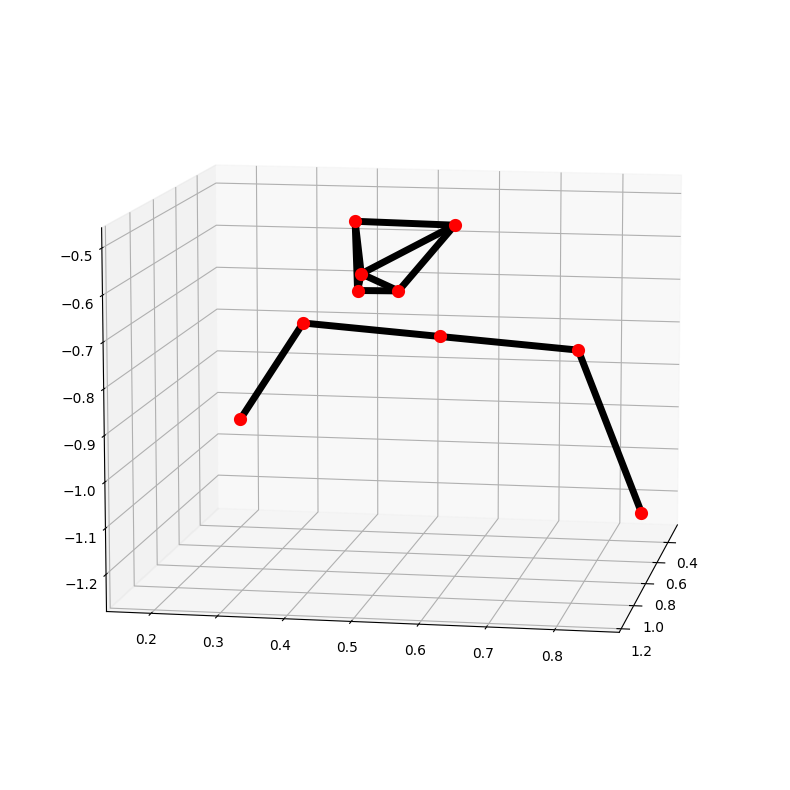

In [22]:
plot_landmarks_modified(landmarks_list, landmark_connections)

In [28]:
captured_landmark_df.loc[1][0] == captured_landmark_df.loc[2][0]

Coordinates
x    False
y    False
z    False
dtype: bool

In [35]:
import queue
a = ['asdasd0']
test = queue.Queue()
test.put(a)

In [36]:
test.empty()

False

In [37]:
test.get()

['asdasd0']

In [45]:
from mediapipe.framework.formats import landmark_pb2

NormLandmark = mp.tasks.components.containers.NormalizedLandmark
NormLandmarkList = landmark_pb2.NormalizedLandmarkList

fefe = NormLandmark()
fefe = []

In [46]:
type(fefe) == list

True

In [47]:
import time

class Func:
    def __init__(self):
        self.running = False

    def start(self):
        if not self.running:
            self.running = True
            self.run()

    def stop(self):
        self.running = False

    def run(self):
        while self.running:
            print("Function running...")
            # Perform some computation or tasks here
            time.sleep(1)

In [62]:
def bb(some_bool: bool = True):
    i = 0
    while some_bool and i <= 10:
        print("Function running...")
        # Perform some computation or tasks here
        i += 1
        time.sleep(1)

def aa()


Function running...


Function running...
Function running...
Function running...
Function running...
Function running...
Function running...
Function running...
Function running...
Function running...
Function running...


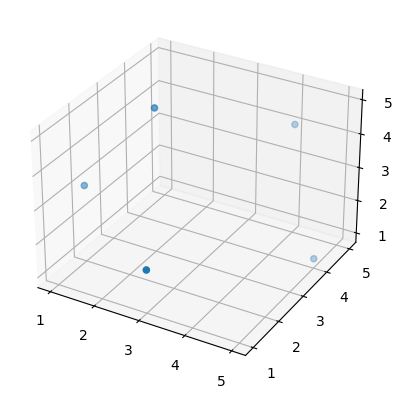

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a figure and axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot some data
x = [1, 2, 3, 4, 5]
y = [2, 3, 1, 5, 4]
z = [3, 5, 2, 4, 1]
ax.scatter(x, y, z)

# # Set the axis limits
ax.set_xlim(0, 6)   # Set x-axis limits
ax.set_ylim(0, 6)   # Set y-axis limits
ax.set_zlim(0, 6)   # Set z-axis limits

# Show the plot
plt.show()


In [93]:
import pandas as pd
start_row = 3
end_row = 10
# Read the CSV file into a DataFrame
# df = pd.read_csv('data\data-2023-07-14-192358.csv', index_col=0)
df = pd.read_csv('data\data-2023-07-14-192358.csv',index_col=0, skiprows=range(1, start_row))


In [94]:
df

,0,0.1,0.2,1,1.1,1.2,2,2.1,2.2,3,...,48.2,49,49.1,49.2,50,50.1,50.2,51,51.1,51.2
Landmarks,,,,,,,,,,,,,,,,,,,,,
1,0.260948,0.329886,3.268673e-07,0.315193,0.316011,-0.022255,0.363390,0.283170,-0.029450,0.398499,...,0.056744,0.993026,0.937909,-0.932671,0.056280,0.907101,-0.181827,0.521675,0.825160,-0.119135
2,-0.261611,-0.460990,1.430190e-01,-0.205110,-0.475219,0.123218,-0.155907,-0.505093,0.113736,-0.123009,...,0.163572,0.467264,0.117391,-0.805542,-0.461608,0.078144,-0.267592,0.000000,0.000000,0.000000
3,0.273274,0.359278,4.469464e-07,0.332227,0.341054,-0.018495,0.386909,0.308322,-0.026385,0.418793,...,0.003027,0.996102,0.953644,-0.931277,0.084620,0.916513,-0.477985,0.536236,0.832628,-0.144343
4,-0.259246,-0.492939,1.192581e-01,-0.202105,-0.507292,0.099721,-0.150024,-0.536802,0.091243,-0.116392,...,0.146397,0.456625,0.116805,-0.764855,-0.439644,0.081786,-0.182706,0.000000,0.000000,0.000000
5,-0.260006,-0.476044,2.435664e-02,-0.203118,-0.489367,0.005093,-0.153600,-0.522823,-0.002958,-0.120153,...,0.123039,0.455192,0.108217,-0.715257,-0.426554,0.073360,-0.155010,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,-0.228868,-0.456053,2.704484e-02,-0.169208,-0.472553,0.011245,-0.118687,-0.512795,0.005478,-0.093290,...,0.076834,0.439225,0.111067,-0.674490,-0.433123,0.117326,-0.434733,0.000000,0.000000,0.000000
176,0.278587,0.393712,4.035426e-07,0.340522,0.373501,-0.015815,0.391681,0.321969,-0.020640,0.413283,...,0.086102,0.954307,0.955457,-0.673025,0.080007,0.970409,-0.422436,0.511338,0.846530,-0.001561
177,-0.229111,-0.437402,3.441397e-02,-0.168114,-0.475604,0.024055,-0.125085,-0.533094,0.027093,-0.105293,...,0.099655,0.443896,0.108620,-0.716389,-0.433430,0.126854,-0.425579,0.000000,0.000000,0.000000


In [171]:
import queue
import pandas as pd

def csv_to_list(path: str = None, start_row: int = 3):
    df = pd.read_csv(path, index_col = 0, skiprows = range(1, start_row))
    landmark_frames = queue.Queue()
    for column in df:
        df[column] = df[column].astype(float)
    for i  in range(1, len(df) + 1):
        container = []
        for j in range(int(len(df.columns)/3)):
            container += [[df[str(j)][i], df[str(j+0.1)][i], df[str(j+0.2)][i]]]
        landmark_frames.put(container)

    # Returns a queue of lists with a format of [[x1, y1, z1],...,[xn, yn, zn]]
    return landmark_frames


In [172]:
path = 'data\data-2023-07-14-192358.csv'
frames = csv_to_list(path=path)

In [50]:
from landmark_animation import *



Landmarks
1    0.260948
2   -0.261611
3    0.273274
4   -0.259246
5   -0.260006
6    0.271594
7   -0.272933
8   -0.284068
Name: 0, dtype: float64